# Chapter 16: A Minimum Implementation of DALL-E

This chapter covers:

* How min DALL-E was trained and how it can generate image based on text prompts
* Use BART encoder to convert a text prompt to an embedding
* Use BART decoder to predict image tokens in an autoregressive fashion based on text embedding
* Use VQGAN detokenizer to convert image tokens into high-resolution images

In this chapter, you'll learn to go through a minimum implementation of DALL-E in PyTorch. You'll then use several pretrained models as the components of the min-DALL-E to generate images with any text prompt. The generated images are coherent and align with text descriptions, even though the quality is not as good as the outputs from OpenAI's DALL-E. This chapter will enable you to have a deep understanding of the steps in the image generation process of the DALL-E model. 

Boris Dayma et al. started a DALL-E mini project in 2022. The project aims to reproduce the results of OpenAI's DALL-E with a smaller architecture. They have achieved impressive results with much smaller hardware resources, even though with a lower quality compared to outputs form DALL-E. The project is implemented with FLAX/JAX instead of PyTorch, see https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-Mini-Explained--Vmlldzo4NjIxODA and https://github.com/borisdayma/dalle-mini for details. Brett Kuprel converted the DALL-E mini into PyTorch and named it min DALL-E. The Python programs in this chapter are adapted from the excellent GitHub repository by Brett Kuprel (https://github.com/kuprel/min-dalle).  

In this chapter, instead of treating DALL-E mini and min DALL-E as black boxes, I'll guide you through the different components of the model. We'll use "panda with top hat reading a book" as the text prompt. I'll teach you how to load up the four components of the trained model: the text tokenizer, the BART encoder, the BART decoder, and the VQGAN detokenizer. You'll see how the prompt is converted to tokens, and then indexes, which are used as inputs to the BART encoder. The encoded text is then fed to the BART decoder to predict image tokens in an autoregressive fashion. The decoded image tokens are fed to the VQGAN detokenizer to convert them into a high-resolution image for you to see on your computer. 

Better yet, you'll see the intermediate steps of the image generation process, what the image looks like when only 25 of the 265 image tokens are generated. What if 58 image tokens are genreated? and so on. These intermediate steps are then converted to animation to illustrate the image generation process, which can be seen here https://gattonweb.uky.edu/faculty/lium/v/minDALLE.gif. 

# 1. How Does DALL-E Mini Work?
In this section, I'll walk you through the idea behind DALL-E mini. How it was trained and how to generate images with text prompts using the trained model.

## 1.1 The Training of DALL-E Mini
The DALL-E mini model architecture is shown in the following diagram.
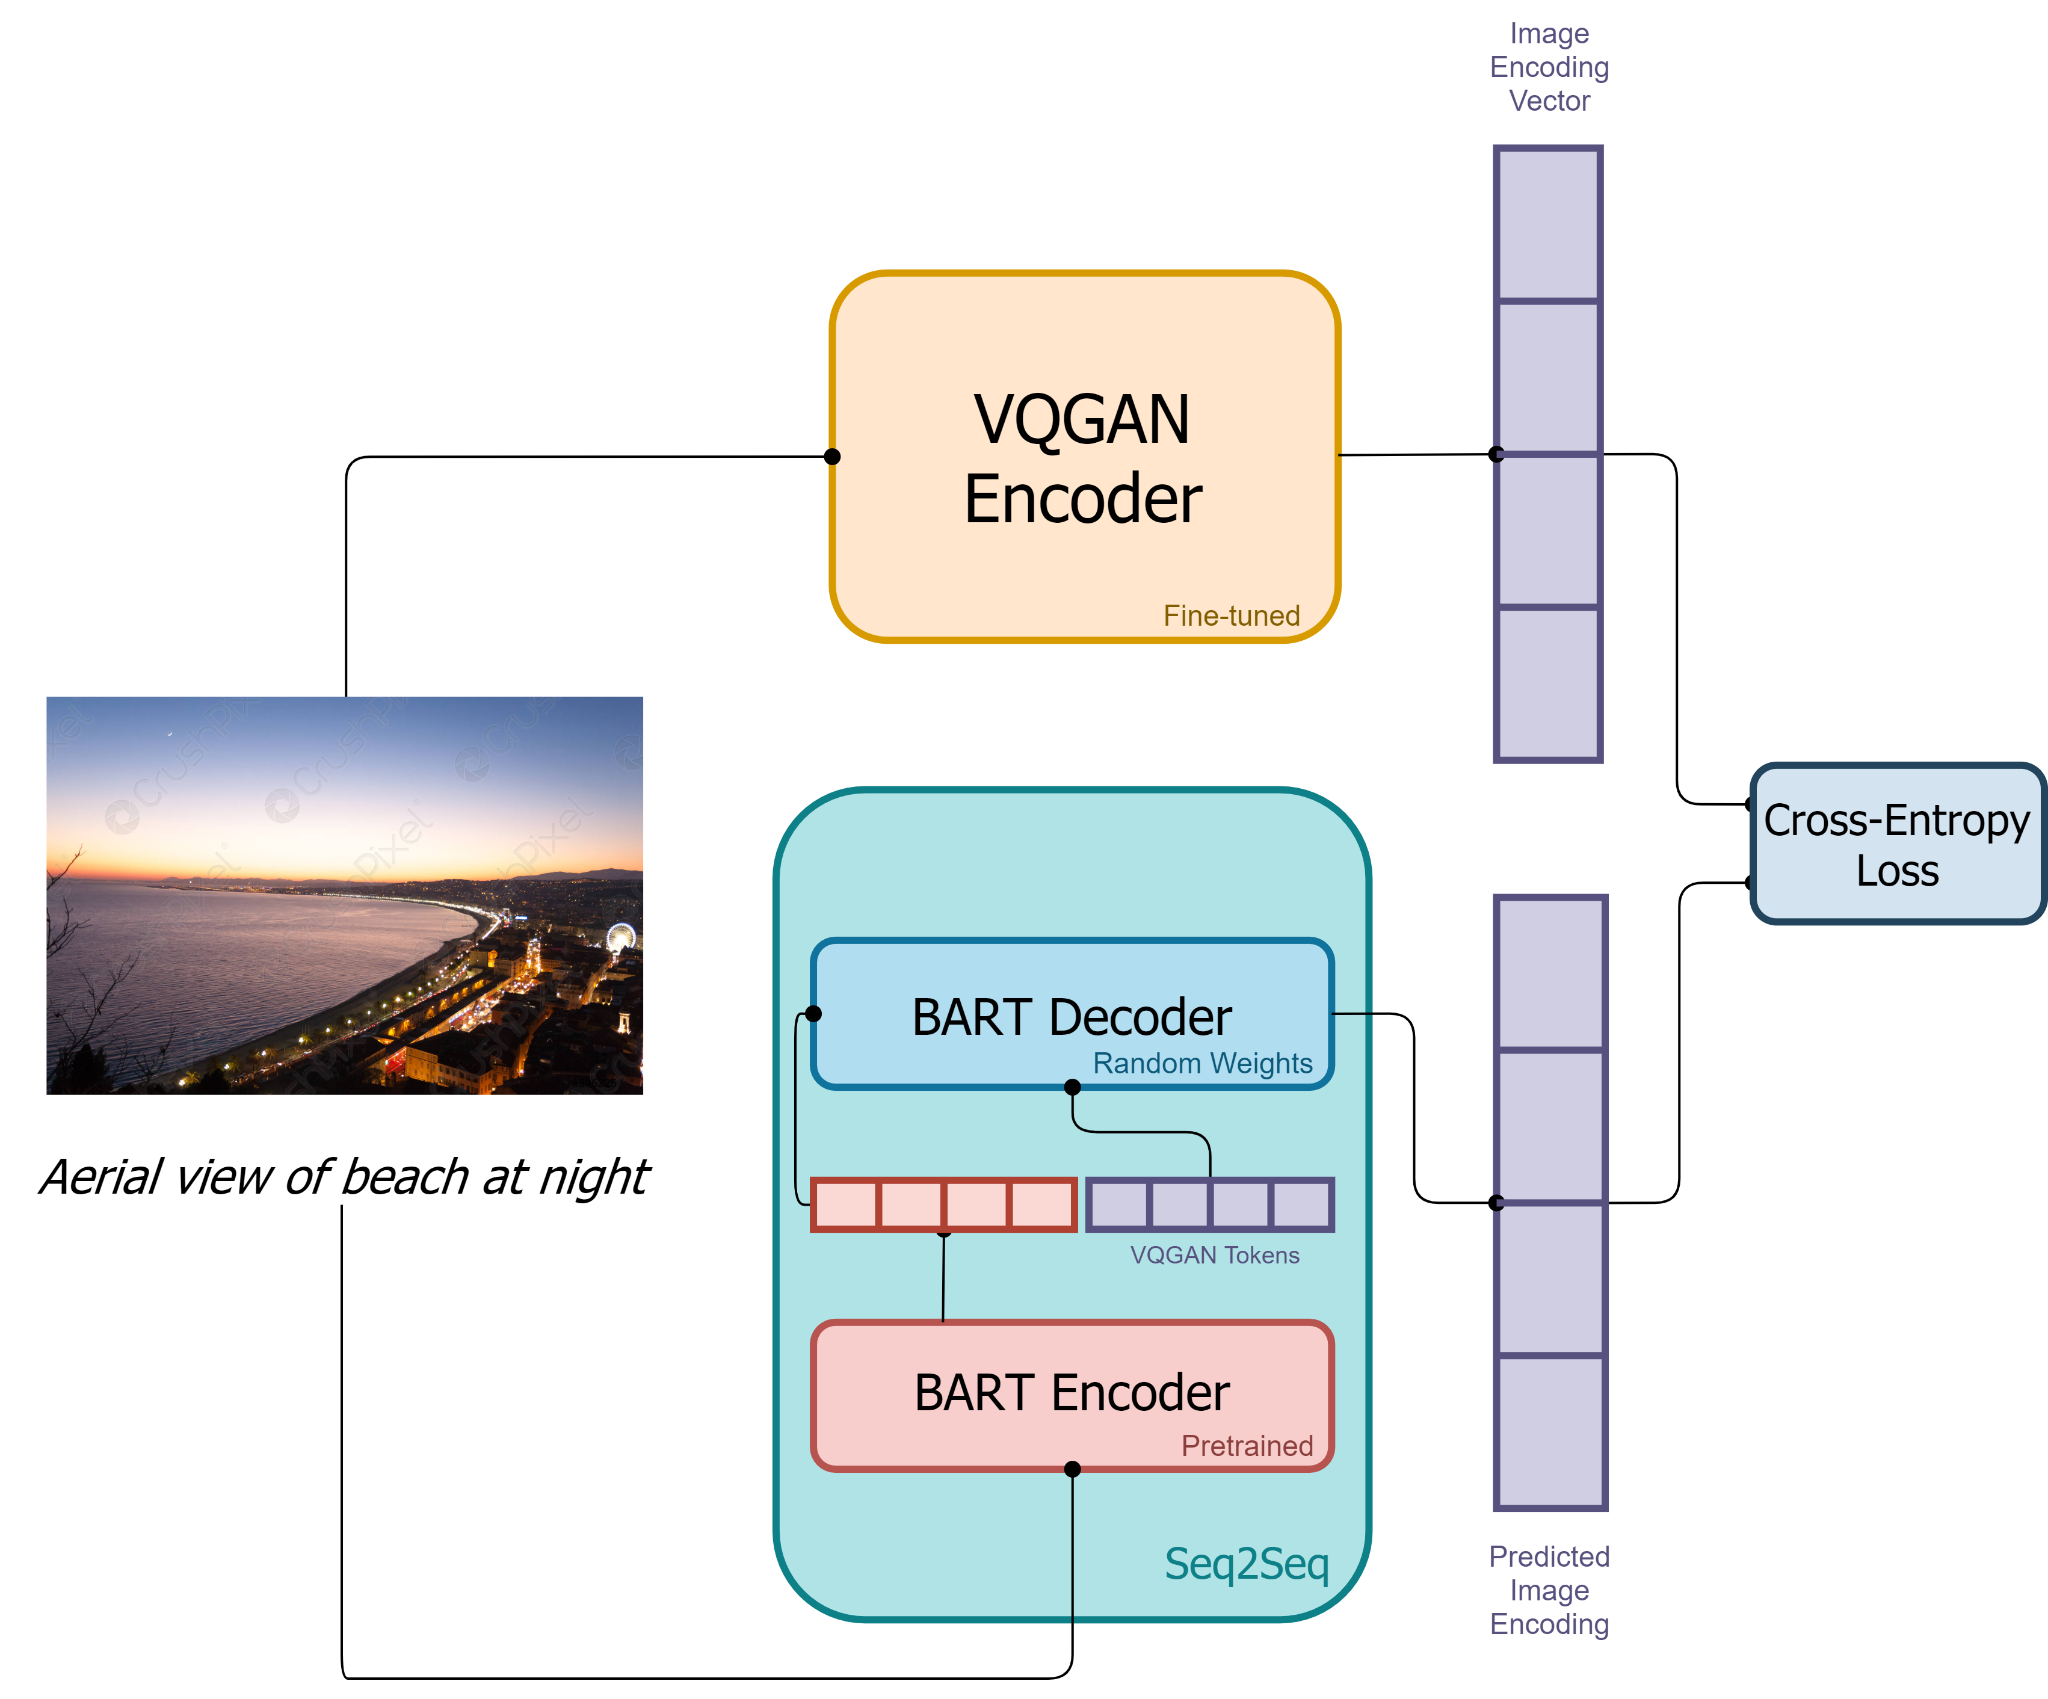

Figure 1: The architecture and training of DALL-E mini (source: https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-Mini-Explained--Vmlldzo4NjIxODA)

About 15 million image-caption pairs were used for training the model. 

During training, images are encoded through a VQGAN encoder into image embeddings. The corresponding captions are passed through a pretrained BART encoder. The output from the BART encoder and image embeddings are fed through the BART decoder, which is trained from scratch. The BART decoder is a decoder-only Transformer, whose goal is to predict the next token. 

We train the model to force the BART decoder to have the same output as the image embedding. That is, the goal of the model is to minimize the cross-entropy loss between the output from the VQGAN encoder and the output from the BART decoder.  

## 1.2 How to Use the Trained DALL-E Mini to Generate Image from Text
Figure 2 below shows how to use the trained DALL-E mini to generate images from text prompts. 

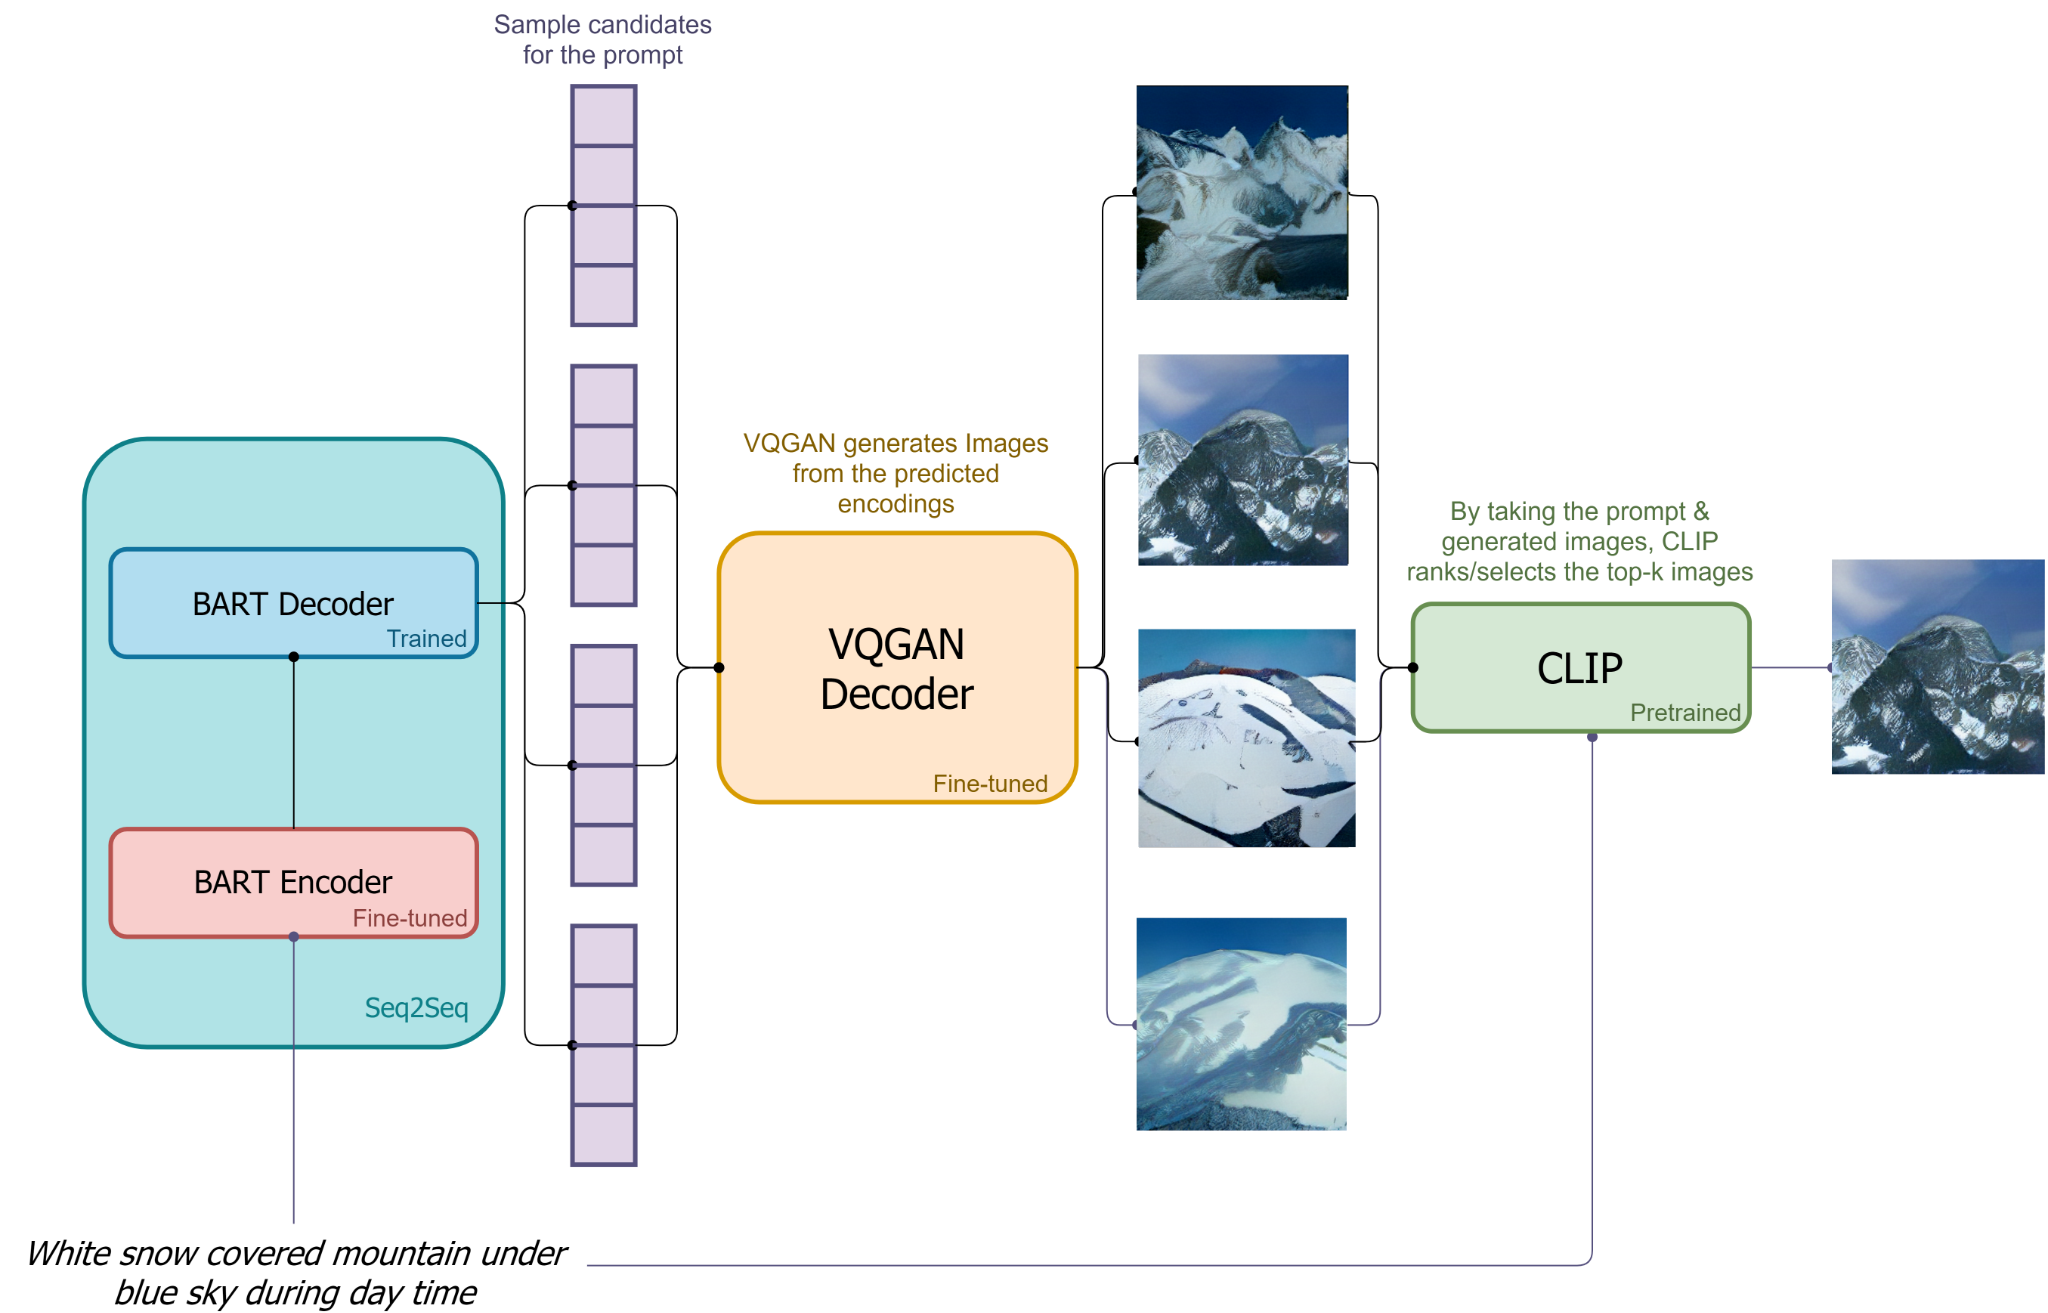

Figure 2: How to use the trained DALL-E mini to generate images from text descriptions (source: https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-Mini-Explained--Vmlldzo4NjIxODA)

To generate images using text prompts, we first tokenize and index the text prompts and feed the sequence into the BART encoder. We then use the trained BART decoder to predict image tokens in an autoregressive fashion. To start, we use a BOS token (special token signaling the start of the sequence) as the input in the first time step to predict the first image token. The predicted image token is then added to the sequence to make prediction for the second image token. We repeat this process until all 256 image tokens are generated in the image. Once all 256 image tokens are completed in the image, we use the pretrained VQGAN decoder to convert image tokens to actual images.

# 2. Tokenize and Encode the Text Prompt
In this section, we'll discuss how to tokenize and encoder the text prompt.

## 2.1 Download the Vocabulary Files
First, we clone the GitHub repository by Brett Kuprel, https://github.com/kuprel/min-dalle, to your computer, like so:

In [1]:
!git clone https://github.com/kuprel/min-dalle

You should see a folder /min-dalle/ on your computer. We'll dive deep into the file min_dalle.py in the /min-dalle/min_dalle/ folder to have a better understand of how various components in min DALL-E work.

Next, we create a couple of folders on your computer to store pretrained models:

In [2]:
import os

if not os.path.exists("pretrained/dalle_bart_mega"):
    os.makedirs("pretrained/dalle_bart_mega")
if not os.path.exists("pretrained/vqgan"):
    os.makedirs("pretrained/vqgan")    

You should see two directories /pretrained/vqgan/ and /pretrained/dalle_bart_mega/ on your computer after running the above code cell. We'll place pretrained models in these two folders later. 

Now, we download two files, vocab.json and merges.txt, from Hugging Face. 

In [3]:
import requests

url='https://huggingface.co/kuprel/min-dalle/resolve/main/'
vocab_path="./pretrained/dalle_bart_mega/vocab.json"
merges_path="./pretrained/dalle_bart_mega/merges.txt"
  
# if either vocab.json or merges.txt is not downloaded    
if not (os.path.exists(vocab_path)
    and os.path.exists(merges_path)):
    print("downloading tokenizer parameters")
    # download the two files to your computer
    vocab = requests.get(url + 'vocab.json')
    merges = requests.get(url + 'merges.txt')
    with open(vocab_path, 'wb') as f: 
        f.write(vocab.content)
    with open(merges_path, 'wb') as f: 
        f.write(merges.content)   
# otherwise, saying files are already downloaded
else:
    print("tokenizer parameters are already downloaded")

tokenizer parameters are already downloaded


If either vocab.json or merges.txt doesn't exist on your computer, the above code cell downloads the two files from Hugging Face and places them in the /pretrain/dalle_bart_mega/ folder on your computer. 

Go to the /pretrain/dalle_bart_mega/ folder and you will see the two files vocab.json and merges.txt.

## 2.2 Initialize the Text Tokenizer
We'll load the vocabulary files and instantiate the TextTokenizer() class in the local module text_tokenizer.py, which you should find in the /min-dalle/min_dalle/ folder.

In [4]:
import sys
sys.path.append("./min-dalle")

import json
from min_dalle.text_tokenizer import TextTokenizer   

print("intializing TextTokenizer")
with open(vocab_path, 'r', encoding='utf8') as f:
    vocab = json.load(f)
with open(merges_path, 'r', encoding='utf8') as f:
    merges = f.read().split("\n")[1:-1]
tokenizer = TextTokenizer(vocab, merges)    

intializing TextTokenizer


You can now use the tokenizer to tokenize the text prompt. 

To understand how it works, we can look at the first ten token-index pairs in the file vocab.json you just downloaded. 

In [5]:
print({k:v for k,v in vocab.items() if v<10}) 

{'<s>': 0, '<pad>': 1, '</s>': 2, '<unk>': 3, '<mask>': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9}


As you can see, the start of the sentence token is mapped to the index 0. The padding token is mapped to the index 1. The end of the sentence token is mapped to the index 2. 

We'll encode the text prompt next. 

## 2.3 Load the Pretrained Encoder
We download the pretrained weights for the encoder from Hugging Face, like this:

In [6]:
encoder_path="./pretrained/dalle_bart_mega/encoder.pt"
  
# if encoder.pt is not downloaded    
if not os.path.exists(encoder_path):
    print("downloading encoder parameters")
    # download encoder.pt to your computer
    ws = requests.get(url + 'encoder.pt')
    with open(encoder_path, 'wb') as f: 
        f.write(ws.content)
# otherwise
else:
    print("encoder parameters are already downloaded")

encoder parameters are already downloaded


We'll instantiate the DalleBartEncoder() class in the local module file dalle_bart_encoder.py in the /min-dalle/min_dalle/models/ folder. 

In [7]:
from min_dalle.models import DalleBartEncoder
import torch

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = "float16" 
print("initializing DalleBartEncoder")
encoder = DalleBartEncoder(
    attention_head_count = 32,
    embed_count = 2048,
    glu_embed_count = 4096,
    text_token_count = 64,
    text_vocab_count = 50272,
    layer_count = 24,
    device=device
).to(getattr(torch, dtype)).eval()
params = torch.load(encoder_path)
encoder.load_state_dict(params, strict=False)
del params
encoder = encoder.to(device)

initializing DalleBartEncoder


The encoder is now loaded with pretrained weights. 

## 2.4 Tokenize and Encode the Text Prompt
We use "panda with top hat reading a book" as our example text prompt and show how it's gradually converted into an image. 

First, we tokenize the text using the tokenizer we created before.

In [8]:
text="panda with top hat reading a book"
tokens = tokenizer.tokenize(text)
print(tokens)

[0, 8418, 208, 479, 2583, 4132, 58, 407, 2]


We converted the text into a list of indexes. We can even look at the raw text tokens by using the vocabulary dictionary.

In [9]:
# a dictionary mapping indexes to tokens
idx2word={v:k for k,v in vocab.items()}
# get raw text tokens
raw_tokens=[idx2word.get(idx,'<unk>') for idx in tokens]
print(raw_tokens)

['<s>', 'Ġpanda', 'Ġwith', 'Ġtop', 'Ġhat', 'Ġreading', 'Ġa', 'Ġbook', '</s>']


Note that the text tokenizer uses 'Ġ' to separate different words so that there is space between words when they are converted back to raw text. 

In [10]:
import numpy
text_tokens = numpy.ones((2, 64), dtype=numpy.int32)
text_tokens[0, :2] = [tokens[0], tokens[-1]]
text_tokens[1, :len(tokens)] = tokens
text_tokens = torch.tensor(text_tokens, 
    dtype=torch.long,device=device)
print(text_tokens)

tensor([[   0,    2,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1],
        [   0, 8418,  208,  479, 2583, 4132,   58,  407,    2,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1]], device='cuda:0')


We create an unconditional prompt by using the starting and end tokens (with indexes 0 and 2, respectively). We then pad both the unconditional prompt and the text prompt to a length of 64. Note the padding index is 1, hence the values you see in the above output. The unconditional prompt is used for classifier free guidance, as we have explained in earlier chapters.

Now we can use the encoder to encode the unconditional prompt and the text prompt.

In [11]:
with torch.cuda.amp.autocast(dtype=getattr(torch, dtype)):
    encoder_state = encoder.forward(text_tokens)
torch.cuda.empty_cache()
print(encoder_state.shape)

torch.Size([2, 64, 2048])


The text embeddings have a shape of (2, 64, 2048): two entries, one for the unconditional text prompt and one for the text prompt. Each entry has 64 tokens in it (padded to a length of 64). Each token is represented by a 2048-value embedding vector. 

# 3. Iterative Prediction of Image Tokens
This section discusses how the trained BART decoder is used to iteratively predict image tokens to form an image. 

## 3.1 Load the Pretrained BART Decoder
We first download the pretrained weights for the BART decoder from Hugging Face.

In [12]:
decoder_path="./pretrained/dalle_bart_mega/decoder.pt"
  
# if decoder.pt is not downloaded    
if not os.path.exists(decoder_path):
    print("downloading decoder parameters")
    # download decoder.pt to your computer
    weights = requests.get(url + 'decoder.pt')
    with open(encoder_path, 'wb') as f: 
        f.write(weights.content)
# otherwise
else:
    print("encoder parameters are already downloaded")

encoder parameters are already downloaded


We instantiate the DalleBartDecoder() class from the local module. If you open the file dalle_bart_decoder.py in the folder /minDALLE/min-dalle/min_dalle/models/ on your computer, you'll see the definition of the DalleBartDecoder() class.

We instantiate the class to create the decoder in our model, like this:

In [13]:
from min_dalle.models import DalleBartDecoder
 
print("initializing DalleBartDecoder")
decoder = DalleBartDecoder(
    image_vocab_count = 16415,
    attention_head_count = 32,
    embed_count = 2048,
    glu_embed_count = 4096,
    layer_count = 24,
    device=device
).to(getattr(torch, dtype)).eval()
params = torch.load(decoder_path)
decoder.load_state_dict(params, strict=False)
del params
decoder = decoder.to(device)

initializing DalleBartDecoder


## 3.2 Predict Image Tokens Using the Trained BART Decoder
As we discussed in Chapter 4, a vision Transformer (ViT) treats an image as a sequence of image tokens. In our setting, we'll divide each image into 256 patches on a 16 by 16 grid. Each image is represented by a sequence of 256 image tokens. During the training stage, we encode both images and their corresponding text captions into this 256-dimensional space and force each image-caption pair to have the same image embedding from the VQGAN encoder and text embedding from the BART decoder.  

At the inference stage, we'll encode the text description into this 256-dimensional space. We then take this 256-value text embedding to the VQGAN decoder to obtain a high-resolution image as our final output. 

For that purpose, we first obtain the text embedding from the trained BART decoder. 

In [14]:
attention_mask = text_tokens.not_equal(1)[:, None, None, :]
print(attention_mask)

attention_state=torch.zeros(size=(24,4,256,2048),device=device)
image_tokens = torch.full((1, 256 + 1), 
    2 ** 14 - 1,dtype=torch.long,device=device)

token_indices=torch.arange(256,device=device)
temperature=0.5
top_k=128
supercondition_factor=4
settings = torch.tensor(
    [temperature, top_k, supercondition_factor], 
    dtype=torch.float32,device=device)

tensor([[[[ True,  True, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False

The attention mask is used to mask out paddings at the end of the input sequence so the model only pays attention to the actual encoded indexes. 

We use the super condition factor, temperature, and top_K sampling to control the creativeness of the output. The super condition factor is a technique used to control the strength of the conditioning information in the generation process. This factor essentially adjusts how strongly the model should adhere to the given conditions or prompts. By modifying this factor, one can influence the fidelity of the generated images to the input conditions.  

Temperature sampling is a method used to control the randomness of predictions in generative models. It modifies the probability distribution of the model's outputs, affecting the creativity and variability of the generated output. A high temperature flattens the probability distribution, making the model more likely to pick less probable outcomes. This increases diversity but can reduce fidelity. In contrast, a low temperature sharpens the probability distribution, making the model more likely to pick the most probable outcomes. 

Top-K sampling limits the model's predictions to the top K most probable outcomes, effectively truncating the probability distribution and sampling from a subset of the most likely results.

In [15]:
# start predicting
from copy import deepcopy

imgtokens=[]
for i in range(256):
    torch.cuda.empty_cache()                
    with torch.cuda.amp.autocast(dtype=getattr(torch, dtype)):
        image_tokens[:, i + 1], \
        attention_state = decoder.sample_tokens(
            settings=settings,
            attention_mask=attention_mask,
            encoder_state=encoder_state,
            attention_state=attention_state,
            prev_tokens=image_tokens[:, [i]],
            token_index=token_indices[[i]])
        imgtokens.append(deepcopy(image_tokens))

We iteratively predict the 256 image tokens. In the first iteration, we predict the image token for the patch in the top left corner of the image. In the first iteration, we predict the image token for the patch in the top row, second column in the image grid, and so on. 

We have created a list imgtokens to contain all intermediate steps so that later we can visualize how the image is created step by step.

# 4. Converting Image Tokens to High-Resolution Images
The image tokens we obtained from the last section are abstract vector representations of image patches, which cannot be displayed on a computer for us to see. 

In this section, we'll use a pretrained VQGAN decoder to convert these image tokens to 256 image patches and stitches them together to form a high-resolution image as the final output. We'll then display and visualize the image. Better yet, we'll visualize how the image would have looked like if we were to convert intermediate steps of the image token predictions into actual images.  

## 4.1 Load the Pretrained VQGAN Detokenizer
We instantiate the VQGanDetokenizer() class from the local module. If you open the file vqgan_detokenizer.py in the folder /minDALLE/min-dalle/min_dalle/models/ on your computer, you'll see the definition of the VQGanDetokenizer() class.

We download the pretrained weights, instantiate the class to create the VQGAN detokenizer in our model, and load the pretrained weights to the detokenizer, as follows:

In [16]:
from min_dalle.models import VQGanDetokenizer

detokenizer_path="./pretrained/vqgan/detoker.pt"
# if detoker.pt is not downloaded    
if not os.path.exists(detokenizer_path):
    print("downloading detokenizer parameters")
    # download detoker.pt to your computer
    ws = requests.get(url + 'detoker.pt')
    with open(detokenizer_path, 'wb') as f: 
        f.write(ws.content)
# otherwise
else:
    print("detokenizer parameters are already downloaded")

print("initializing VQGanDetokenizer")
detokenizer = VQGanDetokenizer().eval()
params = torch.load(detokenizer_path)
detokenizer.load_state_dict(params)
del params
detokenizer = detokenizer.to(device)

detokenizer parameters are already downloaded
initializing VQGanDetokenizer


## 4.2 Visualize the Intermediate and Final High-Resolution Outputs
We first convert the image tokens in the tensor image_tokens to an actual 256x256 image to obtain the final output:

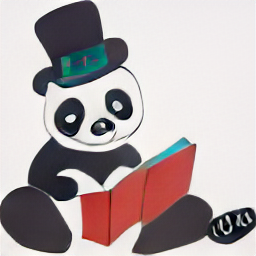

In [17]:
from PIL import Image

torch.cuda.empty_cache()
image = detokenizer.forward(True,image_tokens[:, 1:])         
image = image.to(torch.uint8).to('cpu').numpy()
image=Image.fromarray(image)
image.save("files/minDALLE.png")
image

We also select 8 intermediate steps to visualize how the image was generated step by step. 

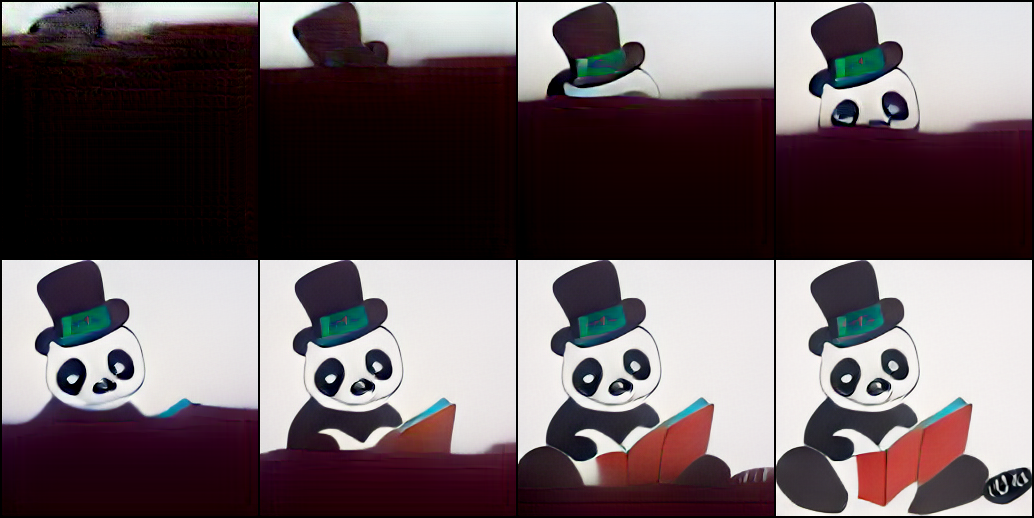

In [18]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
imgs=[]
for i in range(8):
    torch.cuda.empty_cache()
    images = detokenizer.forward(True, 
      imgtokens[16*(2*i+1)+8+i][:, 1:])         
    imgs.append(images.permute(2,0,1).to(torch.uint8))
grid=make_grid(imgs,nrow=4)
img=ToPILImage()(grid)
img.save("files/minDALLEsteps.png")
img

In the 2 by 4 grid, you see 8 images. The top left image shows output when 25 image tokens were generated. The second in the top row shows the output when 58 tokens were generated. The rest images show the outputs when 91, 124, .., 256 image tokens were generated.

You can even make an animation of all the 256 intermediate steps, like so:

In [19]:
vids=[]
for i in range(len(imgtokens)):
    torch.cuda.empty_cache()
    images = detokenizer.forward(True, 
      imgtokens[i][:, 1:])         
    image = images.to(torch.uint8).to('cpu').numpy()
    vids.append(Image.fromarray(image))

import imageio
imageio.mimsave("files/minDALLE.gif",vids,fps=30)

If you go to the /files/ folder on your computer, you'll see the animation minDALLE.gif. It looks like the one I posted on my website https://gattonweb.uky.edu/faculty/lium/v/minDALLE.gif.